In [1]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            # Resize and normalize
            img_resized = cv2.resize(img, (16, 16)) / 255.0
            # Flatten
            img_flattened = img_resized.flatten()
            images.append(img_flattened)
    return np.array(images)

# Load images for class 0 and 5
class_0_images = load_images_from_folder("../data/svm/train/0")
class_5_images = load_images_from_folder("../data/svm/train/5")

class_0_images.shape, class_5_images.shape

((2380, 768), (2380, 768))

# Linear Kernel

In [2]:
from cvxopt import matrix

# Define labels for the two classes: class 0 as -1 and class 5 as +1
y_0 = -1 * np.ones(class_0_images.shape[0])
y_5 = np.ones(class_5_images.shape[0])

# Combine data and labels
X = np.vstack((class_0_images, class_5_images))
y = np.hstack((y_0, y_5))

P = np.outer(y, y) * np.dot(X, X.T)

q = -1 * np.ones(X.shape[0])
A = y
b = 0.0
G = np.vstack((-np.eye(X.shape[0]), np.eye(X.shape[0])))
h = np.hstack((np.zeros(X.shape[0]), np.ones(X.shape[0]) * 1.0))  # C = 1.0

P = matrix(P)
q = matrix(q)
A = matrix(A, (1, X.shape[0]))
b = matrix(b)
G = matrix(G)
h = matrix(h)

P, q, A, b, G, h

(<4760x4760 matrix, tc='d'>,
 <4760x1 matrix, tc='d'>,
 <1x4760 matrix, tc='d'>,
 <1x1 matrix, tc='d'>,
 <9520x4760 matrix, tc='d'>,
 <9520x1 matrix, tc='d'>)

In [3]:
from cvxopt import solvers

# Solve the QP problem
solvers.options['show_progress'] = True
solution = solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -2.5963e+03 -1.3703e+04  7e+04  3e+00  1e-10
 1: -1.7917e+03 -1.0056e+04  2e+04  5e-01  8e-11
 2: -1.5840e+03 -5.2708e+03  5e+03  8e-02  6e-11
 3: -1.7450e+03 -2.7358e+03  1e+03  2e-02  6e-11
 4: -1.8993e+03 -2.3548e+03  5e+02  6e-03  6e-11
 5: -1.9660e+03 -2.2023e+03  2e+02  3e-03  6e-11
 6: -2.0104e+03 -2.1059e+03  1e+02  8e-04  7e-11
 7: -2.0286e+03 -2.0666e+03  4e+01  8e-05  7e-11
 8: -2.0403e+03 -2.0484e+03  8e+00  5e-06  8e-11
 9: -2.0429e+03 -2.0448e+03  2e+00  9e-07  7e-11
10: -2.0436e+03 -2.0439e+03  3e-01  1e-07  7e-11
11: -2.0437e+03 -2.0438e+03  2e-02  7e-09  8e-11
12: -2.0437e+03 -2.0437e+03  7e-04  2e-10  8e-11
Optimal solution found.


In [4]:
# Extract alphas
alphas = np.array(solution['x'])

# Calculate w using the alphas
w = np.sum(alphas * y[:, None] * X, axis=0)

# Calculate b
SV = (alphas > 1e-5).flatten()
b = y[SV] - np.dot(X[SV], w)
b = np.mean(b)

# For predictions: np.sign(np.dot(X, w) + b)

print("Weight vector (w):", w)
print("Intercept (b):", b)

Weight vector (w): [-0.917249   -0.44200238  0.84523203 -0.84925474 -0.47666238  1.01249138
  0.20687805 -0.79081624  0.58541163  0.01083122  0.29591497 -0.20428939
 -0.23601894 -0.13552678  0.00948478  0.2784127   0.25000897 -0.59609479
  0.51654891 -0.00238444 -0.72837606  0.38641764  1.16391137 -0.7230097
  0.59917949 -0.19686843  0.22879539  0.00548266 -0.00485189 -0.20635175
 -0.24939613  0.27754466 -0.10042862 -0.51068156  0.05413774  0.23309896
 -0.32542179 -0.50001089  1.03614665 -0.51392529  0.01316362  0.56835031
 -0.04939489  0.03226088 -0.08872812 -0.38552074 -0.50806367  0.67213466
 -0.02636468 -0.13882351  0.15677769 -0.33964974 -0.03108468  0.44170137
 -0.13756015 -0.05824047  0.21480715  0.67770761 -0.19013527 -1.07471117
  0.00286474  0.05826787 -0.07360596 -0.05182642  0.30970803 -0.24139411
 -1.45793583  0.62065892  0.69815229  0.135206   -0.02020839 -0.20654098
  0.1084027  -0.43200058  0.04193463 -0.73189424  0.49437739 -0.00917455
  0.66627935 -0.07171418 -0.34792

In [5]:
support_vector_indices = alphas > 1e-5

num_support_vectors = np.sum(support_vector_indices)

percentage_support_vectors = (num_support_vectors / X.shape[0]) * 100

num_support_vectors, percentage_support_vectors

(2383, 50.063025210084035)

In [6]:
# Validation

# load images for class 0 and 5
class_0_images_val = load_images_from_folder("../data/svm/val/0")
class_5_images_val = load_images_from_folder("../data/svm/val/5")

# Define labels for the two classes: class 0 as -1 and class 5 as +1
y_0_val = -1 * np.ones(class_0_images_val.shape[0])
y_5_val = np.ones(class_5_images_val.shape[0])

# Combine data and labels
X_val = np.vstack((class_0_images_val, class_5_images_val))
y_val = np.hstack((y_0_val, y_5_val))

# Predict
y_pred = np.sign(np.dot(X_val, w) + b)

# Calculate accuracy
accuracy = np.sum(y_pred == y_val) / y_val.shape[0]

print("Accuracy:", accuracy)

Accuracy: 0.775


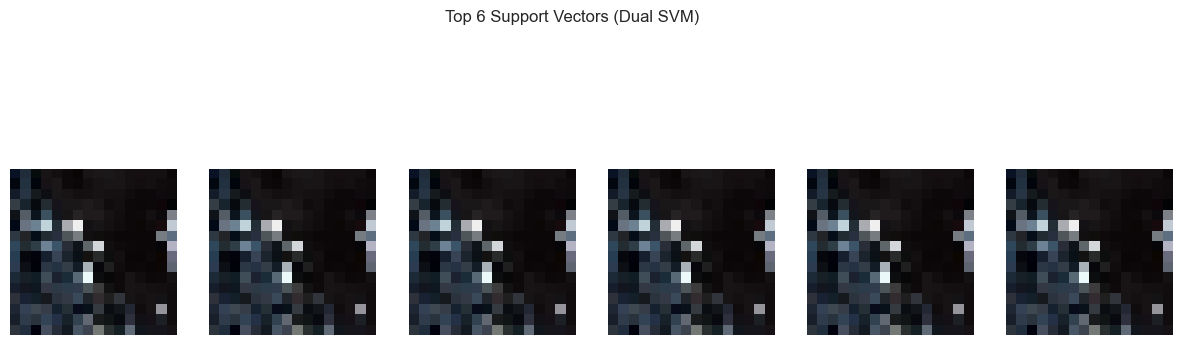

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


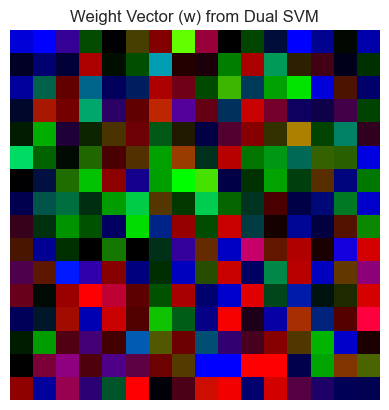

In [7]:
import matplotlib.pyplot as plt

# Get support vectors and their coefficients from the dual solution
support_vectors_dual = X[SV]
dual_coefs = alphas[SV]

# Get indices of top 6 coefficients
top_indices_dual = np.argsort(dual_coefs)[-6:]

# Reshape and plot the support vectors corresponding to top 6 coefficients
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(support_vectors_dual[top_indices_dual[i]].reshape(16, 16, 3))
    ax.axis('off')

plt.suptitle("Top 6 Support Vectors (Dual SVM)")
plt.savefig("top_6_support_vectors_dual cvxopt linear.png")
plt.show()

# Reshape and plot the weight vector w
plt.imshow(w.reshape(16, 16, 3))
plt.title("Weight Vector (w) from Dual SVM")
plt.axis('off')
plt.savefig("weight_vector_dual cvxopt linear.png")
plt.show()

# Gaussian Kernel

In [8]:
def gaussian_kernel(x1, x2, gamma=0.001):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)


In [9]:
P = np.zeros((X.shape[0], X.shape[0]))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        P[i, j] = y[i] * y[j] * gaussian_kernel(X[i], X[j])

In [10]:
from cvxopt import matrix, solvers
from numpy import double

q = -np.ones((X.shape[0], 1))
G = np.vstack([-np.eye(X.shape[0]), np.eye(X.shape[0])])
h = np.hstack([np.zeros(X.shape[0]), np.ones(X.shape[0]) * 1.0])  # Considering C = 1.0
A = y.reshape(1, -1)
b = np.zeros(1)

P = matrix(P)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b)

sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -3.0573e+03 -1.3944e+04  7e+04  3e+00  6e-13
 1: -2.0948e+03 -1.0001e+04  1e+04  2e-01  6e-13
 2: -2.2663e+03 -3.4451e+03  1e+03  2e-02  5e-13
 3: -2.6058e+03 -3.0009e+03  4e+02  5e-03  5e-13
 4: -2.7139e+03 -2.8783e+03  2e+02  2e-03  6e-13
 5: -2.7605e+03 -2.8255e+03  7e+01  6e-04  6e-13
 6: -2.7804e+03 -2.8029e+03  2e+01  2e-04  6e-13
 7: -2.7888e+03 -2.7935e+03  5e+00  2e-05  6e-13
 8: -2.7908e+03 -2.7913e+03  5e-01  2e-06  7e-13
 9: -2.7910e+03 -2.7910e+03  2e-02  6e-08  7e-13
10: -2.7910e+03 -2.7910e+03  7e-04  2e-09  6e-13
Optimal solution found.


In [ ]:
sv_indices_b_gaussian = ((alphas < 1 - 1e-8) & (alphas > 1e-5)).flatten()
support_vectors = X[sv_indices_b_gaussian]
support_vector_labels = y[sv_indices_b_gaussian]
alphas_sv = alphas[sv_indices_b_gaussian]

b = np.mean([support_vector_labels[i] - np.sum(alphas_sv.flatten() * support_vector_labels.flatten() * np.exp(-0.001 * (np.linalg.norm(support_vectors - support_vectors[i], axis=1) ** 2)).flatten()) for i in range(alphas_sv.shape[0])])

print(b)

In [ ]:
# Extract support vectors
sv_indices_w_gaussian = (alphas > 1e-5).flatten()
print(np.sum(sv_indices_w_gaussian))
support_vectors = X[sv_indices_w_gaussian]
support_vector_labels = y[sv_indices_w_gaussian]
alphas_sv = alphas[sv_indices_w_gaussian]

In [ ]:
def predict_gaussian(X):
    y_pred = []
    for x in X:
        prediction = np.sum(alphas_sv.flatten() * support_vector_labels.flatten() * np.exp(-0.001 * (np.linalg.norm(support_vectors - x, axis=1) ** 2)).flatten()) + b
        print(prediction)
        y_pred.append(np.sign(prediction))
    return np.array(y_pred)

y_val_pred = predict_gaussian(X_val)
val_accuracy_gaussian = np.mean(y_val_pred == y_val)

val_accuracy_gaussian